- Initially you will see grayscale images
- Yellow shades and blue shades will be learned first.
- Red shade is learned eventually.
- Green shade is learned very late. Takes about 5 epochs.

## Download and Prepare Dataset

COCO Dataset - Terms of use: http://cocodataset.org/#termsofuse

Skip these cells if COCO dataset is already downloaded.

In [0]:
# Download Dataset
!wget http://images.cocodataset.org/zips/unlabeled2017.zip

--2019-09-19 12:37:15--  http://images.cocodataset.org/zips/unlabeled2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.186.35
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.186.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20126613414 (19G) [application/zip]
Saving to: ‘unlabeled2017.zip’

unlabeled2017.zip     1%[                    ] 205.79M  16.7MB/s    eta 21m 26s

In [0]:
# Extract Dataset
#!mkdir data
!unzip unlabeled2017.zip -d ./data >> /dev/null

## Code

In [0]:

from matplotlib import pyplot as plt
import numpy as np

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dset
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from IPython import display
from PIL import Image

%matplotlib inline

In [0]:
# Configurations
dataroot = "./data"

image_size = 256
nb_channls=3
workers=4
num_epochs = 10
batch_size = 8
learning_rate = 1e-3
weight_decay = 1e-5

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), nb_channls, image_size, image_size)
    return x

device

In [0]:
# Load Dataset
'''
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((image_size//4, image_size//4)),
                               transforms.ToTensor(),
                           ]),
                           target_transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                           ]))
                           '''
from torch.utils.data import Dataset
from torchvision.datasets.folder import ImageFolder
from PIL import Image

import os
import os.path
import sys

class MyDataset(ImageFolder):
    def __init__(self, root, input_transform=None, output_transform=None):
        super(MyDataset, self).__init__(root, transform=input_transform)
        self.input_transform = input_transform
        self.output_transform = output_transform
        
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        
        if self.transform:
            img1 = self.input_transform(img)
            img2 = self.output_transform(img)
            
        return img1, img2


dataset = MyDataset(dataroot,
                    input_transform=transforms.Compose([
                        transforms.Resize((image_size//4, image_size//4)),
                        transforms.ToTensor(),
                    ]),
                    output_transform=transforms.Compose([
                        transforms.Resize((image_size, image_size)),
                        transforms.ToTensor(),
                    ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [0]:
import numpy as np
from sys import getsizeof


import torch
from torch import nn
class SuperResST8(torch.nn.Module):
    def __init__(self):
        super(SuperResST8, self).__init__()
        self.itr = 0
        self.d_block3 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1)),
        )
        self.residual_in = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=(1, 1), stride=(1, 1))


        # 512 * 128 * 128
        self.d_up_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 512 * 256 * 256
        self.d_up_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 512 * 256 * 256
        self.d_up_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 64 * 256 * 256
        self.d_block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((2, 2, 2, 2)),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 3 * 256 * 256
        self.d_block5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((2, 2, 2, 2)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
        )

        # one x one convultion to match shape of up_conv3 and block4
        self.residual_out = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), stride=(1, 1))

        self.down_sample = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=(2, 2)),
            nn.Tanh()
        )


    def forward(self, x):
        a = self.d_block3(x)
        b = self.residual_in(x)
        x = a + b
        x = self.d_up_conv2(x)
        x = self.d_up_conv3(x)
        x = self.d_up_conv4(x)
        x = self.d_block4(x) + self.residual_out(x)
        x = self.d_block5(x)
        x = self.down_sample(x)
        return x



In [0]:
from google.colab import files
uploaded = files.upload()


In [0]:
# Compile Network
#model = SuperResolver().to(device)
model = SuperResST8().to(device)
state_dict = torch.load('./superresST8_perc_3500.pth')
#model.load_state_dict(state_dict)
#model.itr = 1001

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#summary(encoder_model, (nb_channls, image_size, image_size))
#summary(decoder_model, (1024, 1, 1))
summary(model, (nb_channls, image_size//4, image_size//4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1            [-1, 3, 66, 66]               0
            Conv2d-2          [-1, 128, 64, 64]           3,584
         LeakyReLU-3          [-1, 128, 64, 64]               0
   ReflectionPad2d-4          [-1, 128, 66, 66]               0
            Conv2d-5          [-1, 256, 64, 64]         295,168
            Conv2d-6          [-1, 256, 64, 64]           1,024
            Conv2d-7           [-1, 64, 62, 62]         147,520
         LeakyReLU-8           [-1, 64, 62, 62]               0
   ReflectionPad2d-9           [-1, 64, 64, 64]               0
  ConvTranspose2d-10        [-1, 256, 128, 128]          65,792
           Conv2d-11         [-1, 64, 126, 126]         147,520
        LeakyReLU-12         [-1, 64, 126, 126]               0
  ReflectionPad2d-13         [-1, 64, 128, 128]               0
  ConvTranspose2d-14        [-1, 256, 2

In [0]:
import copy
def create_loss_model(vgg, end_layer, use_maxpool=True, use_cuda=False):
    """
        [1] uses the output of vgg16 relu2_2 layer as a loss function (layer8 on PyTorch default vgg16 model).
        This function expects a vgg16 model from PyTorch and will return a custom version up until layer = end_layer
        that will be used as our loss function.
    """

    vgg = copy.deepcopy(vgg)

    model = nn.Sequential()

    if use_cuda:
        model.to(device)

    i = 0
    for layer in list(vgg):

        if i > end_layer:
            break

        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            if use_maxpool:
                model.add_module(name, layer)
            else:
                avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
                model.add_module(name, avgpool)
        i += 1
    return model

vgg16 = torchvision.models.vgg16(pretrained=True).features.to(device)

vgg_loss = create_loss_model(vgg16, 8, use_cuda=True)

for param in vgg_loss.parameters():
    param.requires_grad = False



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


iter [0], loss:343209.281250 15244235.000000 358453.531250


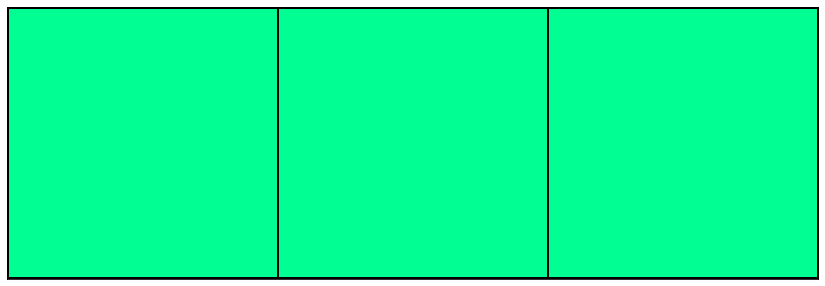

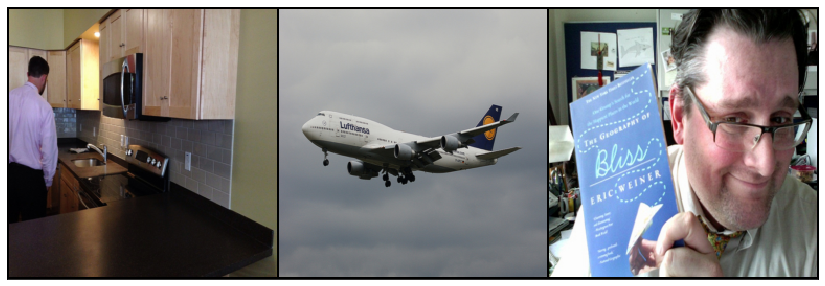

In [0]:
torch.autograd.set_detect_anomaly(True)
# Training Loop. Results will appear every 50th iteration.
for epoch in range(num_epochs):
    for data in dataloader:
        img, orig_img = data   
        img = Variable(img).to(device)
        orig_img = Variable(orig_img).to(device)

        # Forward
        output = model(img)

        loss = torch.nn.MSELoss(size_average=False)(output, orig_img)
        loss_ = torch.nn.MSELoss(size_average=False)(vgg_loss(output), vgg_loss(orig_img))
        total = loss+1e-3*loss_
       
        # Backprop
        optimizer.zero_grad()
        total.backward()
        optimizer.step()
       
        if model.itr % 50 == 0:
            # Log
            print('iter [{}], loss:{:f} {:f} {:f}'
              .format(model.itr, loss.data.item(), loss_.data.item(), total.data.item()))
            pic = to_img(output.to("cpu").data)
            orig = to_img(orig_img.to("cpu").data)
        
          
            fig = plt.figure(  figsize=(15, 5),)
            btch = pic.to(device)[:3]
            ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2, normalize=True).cpu(),(1,2,0)))
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            plt.show(fig)
            fig = plt.figure(  figsize=(15, 5),)
            btch = orig.to(device)[:3]
            ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2, normalize=True).cpu(),(1,2,0)))
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            plt.show(fig)
        
        if model.itr % 500 == 0:
          torch.save(model.state_dict(), './superresST8_perc_'+str(model.itr)+'.pth')
          #import time
          #time.sleep(20)
          #from google.colab import files
          #files.download('./superres_'+str(itr)+'.pth')
            
        model.itr += 1

    print('epoch [{}/{}], loss:{:f}'
          .format(epoch + 1, num_epochs, loss.data.item()))

In [0]:


# Preview Results
for data in dataloader:
  img, _ = data        
  img = Variable(img).to(device)
  output = model(img)
  break

In [0]:
# Preview before compression
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(img.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# Preview after compression
pic = to_img(output.to("cpu").data)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(pic.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
!ls .

In [0]:
# Download Weights
from google.colab import files
files.download('./superresST8_perc_3000.pth')


In [0]:
print(encoder_model.state_dict())